### Deriving pulsar properties from PWNe - testing
* Pair-production multiplicity via de Jager 2007 $<k> = \frac{N_e({\rm obs})}{2N_{GJ}}$
* Initial spin-down period $P_0$ via van de Swaluw 2001 & the ratio $R_{pwn}/R_{snr}$
* Relate $k$ to the fraction of hadronic particles present in the PWN (and hence hadronic emission component) 

In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from psrqpy import QueryATNF
import matplotlib.pylab as pylab
from cycler import cycler
from itertools import cycle
from scipy.integrate import simps
from matplotlib.pyplot import cm
import tabulate

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large',
          'ytick.labelsize':'xx-large'}

pylab.rcParams.update(params)
plt.style.use('tableau-colorblind10')

%matplotlib inline

In [2]:
# Choose parameters from ATNF (or query the whole database)
query = QueryATNF() #params=['Edot','age',"dist","P0","P1","BINARY"])

In [3]:
# Convert them to PANDAS
table = query.table
table = table.to_pandas()

age_all = table["AGE"]
edot_all = table["EDOT"]
dist = table["DIST"]
period = table["P0"]
pdot = table["P1"]
#fatnf = 2*np.pi/np.asarray(period)/u.s

# Compute beam fraction correction
beam_fraction = 9 * np.power(np.log10((period)/10), 2) + 3
beam_fraction /= 100

# Selection to remove milli-second pulsars
sel = np.logical_and(np.invert(np.isnan(age_all)), np.invert(np.isnan(edot_all)))
sel = np.logical_and(sel, dist < 25) #within the Milky Way
sel = np.logical_and(sel, period > 0.01)
sel = np.logical_and(sel, pdot > 1e-18)
sel = np.logical_and(sel, age_all < 1e7)

#print(max(age))
#Now apply selection mask 
age_all = age_all[sel]

edot_all = edot_all[sel]
beam_fraction = beam_fraction[sel]
#dist = dist[sel]
#period = period[sel]
#pdot = pdot[sel]

### Pair-production mutiplicity
1) Use Halo paper results for known HESS PWNe to obtain $N_e$ via observations 
* i.e. use energy densities provided and properties of the assumed electron spectrum 
* Note: $E_{\rm min} = 100$GeV, $E_{\rm max}=1,3,10$TeV and $\Gamma = 2.2$

2) Use ATNF catalogue to obtain $N_{GJ}$ for the same pulsars via known properties
* see also eqn(2) of de Jager for the simplified version of $\dot{E}$


In [4]:
import pandas as pd

df = pd.read_csv("Pulsar_PWNe_properties - table_pulsars.csv")

In [5]:
df.columns

Index(['Name', 'ATNF J name', 'Edot [erg/s]', 'Size [pc]', 'Distance [kpc]',
       'Age [kyr]', 'Total_E [erg]', 'Volume [cm^3]', 'Edens [eV/cm^-3]',
       'mean_edens [eV/cm^-3]', 'min_edens [eV/cm^-3]', 'max_edens [eV/cm^-3]',
       'E_Threshold [TeV]', 'R_SNR [pc]', 'R_PWN [pc]', 'R_TeV [pc]',
       'R_Xray [pc]', 'LHAASO E_gmax (PeV)', 'LHAASO E_emax (PeV)',
       'Unnamed: 19', 'dN_e/dE', 'E_low [TeV]', 'E_0 [TeV]', 'E_max [TeV]',
       'N_e [cm^-3]', 'Notes', 'Unnamed: 26'],
      dtype='object')

In [6]:
#Obtain period and pdot from ATNF
atnf_names=df['ATNF J name']

period_atnf = np.zeros(len(df))
pdot_atnf = np.zeros(len(df))
print(table["NAME"][sel])
for i in range(len(df)):
    psr_idx = np.where(table["NAME"]==atnf_names[i])[0][0]
    period_atnf[i] = period[psr_idx]
    pdot_atnf[i] = pdot[psr_idx]


0       J0002+6216
1       J0006+1834
2       J0007+7303
45      J0040+5716
49      J0048+3412
           ...    
3335    J2325+6316
3342    J2330-2005
3345    J2337+6151
3355    J2354+6155
3358    J2355+2246
Name: NAME, Length: 1244, dtype: object


In [7]:
#Define properties of electron spectrum as per the halos paper
E0 = 1. *u.TeV
E2 = 10. *u.TeV #1, 3 or 10
#E1 = 0.1 *u.TeV
E1 = df['E_Threshold [TeV]']*u.TeV
Gam = 2.2

pow2 = 2-Gam
integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))

#Integration constant is total energy (from halos paper) divided by electron spectrum integral
print(df['E_Threshold [TeV]'])
k_intconst = df["Total_E [erg]"]*u.erg / integral2

0       NaN
1       NaN
2     0.387
3     0.388
4     0.610
5     0.894
6     0.759
7     0.501
8     0.395
9     0.470
10    0.388
11    0.759
12    0.784
13    0.396
14    0.683
15    0.694
16      NaN
17    0.170
18      NaN
19      NaN
20    0.532
21    0.742
22      NaN
23    0.492
24    0.442
25    0.442
26    0.428
27    0.587
28    0.757
29    0.757
30    0.383
31    0.383
32      NaN
33    0.389
34    0.744
35    0.388
36    0.388
37    0.492
38      NaN
39      NaN
40    0.379
41    0.379
42      NaN
43      NaN
44      NaN
45      NaN
46      NaN
47      NaN
Name: E_Threshold [TeV], dtype: float64


In [8]:
pow1 = 1-Gam
integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1

Nel = k_intconst*integral
#Number of electrons derived from observations
print(Nel[0])

nan


In [9]:
#for convenience
yr_to_s = (1. * u.yr).to(u.s)

In [10]:
#Edot and age as used in halos paper: 
edot = np.zeros(len(df))
age_halo = np.zeros(len(df))

for i in range(len(df)):
#     print(i)
    edot[i] = df["Edot [erg/s]"][i] 
    age_halo[i] = df["Age [kyr]"][i]
    

edot *= u.erg / u.s
age_halo *= u.kyr
# print(age_halo)

In [11]:
#Calculate age as a function of P0

def age_p0(psr_period,psr_pdot,p0=0.01*u.s,n=3):
    
    brk = n-1
    argp = p0/(psr_period*u.s)
    tau_age = 1. - argp**brk
    tau_age *= (psr_period*u.s)/(brk*psr_pdot)
    return tau_age.to(u.yr)

In [12]:
#Range of initial spin periods 
test_p0 = np.linspace(0.01,0.15,300)*u.s
print(test_p0)

[0.01       0.01046823 0.01093645 0.01140468 0.01187291 0.01234114
 0.01280936 0.01327759 0.01374582 0.01421405 0.01468227 0.0151505
 0.01561873 0.01608696 0.01655518 0.01702341 0.01749164 0.01795987
 0.01842809 0.01889632 0.01936455 0.01983278 0.020301   0.02076923
 0.02123746 0.02170569 0.02217391 0.02264214 0.02311037 0.0235786
 0.02404682 0.02451505 0.02498328 0.02545151 0.02591973 0.02638796
 0.02685619 0.02732441 0.02779264 0.02826087 0.0287291  0.02919732
 0.02966555 0.03013378 0.03060201 0.03107023 0.03153846 0.03200669
 0.03247492 0.03294314 0.03341137 0.0338796  0.03434783 0.03481605
 0.03528428 0.03575251 0.03622074 0.03668896 0.03715719 0.03762542
 0.03809365 0.03856187 0.0390301  0.03949833 0.03996656 0.04043478
 0.04090301 0.04137124 0.04183946 0.04230769 0.04277592 0.04324415
 0.04371237 0.0441806  0.04464883 0.04511706 0.04558528 0.04605351
 0.04652174 0.04698997 0.04745819 0.04792642 0.04839465 0.04886288
 0.0493311  0.04979933 0.05026756 0.05073579 0.05120401 0.051672

In [13]:
#Calculate N_GJ integral, check current day values

def calc_ngj(edot_pwn,age_pwn,psr_age=10**3*u.yr,alpha=2):
    
    
    ys=np.arange(len(age_pwn),dtype='float64')
    for i in np.arange(len(ys)):
        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)
        edot_pwnt=edot_pwn*(1+t/psr_age)**alpha
        edot_pwnt=edot_pwnt.to(u.erg/u.s)
        integrand=1*(6*c.c.cgs*edot_pwnt)**0.5/c.e.gauss
        y=simps(integrand,t)
        ys[i]=y
    return ys
'''
#Plot edot (PWN,t), from Gunn and Ostriker, assumes theta=pi/4
def calc_ngj(age_pwn,patnf,Bp=10**12*u.cm**-0.5*u.g**0.5/u.s,a=(10*u.km).to(u.cm),theta=np.pi/4,I=1.4e45*u.g*u.cm**2):
    ys=np.arange(len(age_pwn),dtype='float64')
    fatnfc=2*np.pi/patnf/u.s
    print(patnf,fatnfc)
    for i in np.arange(len(ys)):
        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)
        tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)
        edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)
        edot_pwn=edot_pwn.to(u.erg/u.s)
        integrand=1*(6*c.c.cgs*edot_pwn)**0.5/c.e.gauss
        y=simps(integrand,t)
        ys[i]=y
    return ys
'''

"\n#Plot edot (PWN,t), from Gunn and Ostriker, assumes theta=pi/4\ndef calc_ngj(age_pwn,patnf,Bp=10**12*u.cm**-0.5*u.g**0.5/u.s,a=(10*u.km).to(u.cm),theta=np.pi/4,I=1.4e45*u.g*u.cm**2):\n    ys=np.arange(len(age_pwn),dtype='float64')\n    fatnfc=2*np.pi/patnf/u.s\n    print(patnf,fatnfc)\n    for i in np.arange(len(ys)):\n        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)\n        tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)\n        edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)\n        edot_pwn=edot_pwn.to(u.erg/u.s)\n        integrand=1*(6*c.c.cgs*edot_pwn)**0.5/c.e.gauss\n        y=simps(integrand,t)\n        ys[i]=y\n    return ys\n"

In [14]:
#Check Edot for J1513-5908
psr_idx = np.where(table["NAME"]=='J1513-5908')[0][0]
period_atnfi = period[psr_idx]
pdot_atnfi = pdot[psr_idx]
print(period_atnfi,pdot_atnfi)
Bp=10**12*u.cm**-0.5*u.g**0.5/u.s
a=(10*u.km).to(u.cm)
theta=np.pi/4
I=1.4e45*u.g*u.cm**2
age_pwni=age_p0(period_atnfi,pdot_atnfi)
Edotjager=I*(2*np.pi/period_atnfi/u.s)*(2*np.pi/pdot_atnfi/u.s**2)

fatnfc=2*np.pi/period_atnfi/u.s
t=np.linspace(0*u.s,age_pwni.to(u.s),100)
tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)
edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)
edot_pwn=edot_pwn.to(u.erg/u.s)
print(Edotjager.to(u.erg/u.s),edot_pwn)

0.15158194339345915 1.5286897617091928e-12
2.385178822708124e+59 erg / s [9.13032498e+33 9.13025585e+33 9.13018674e+33 9.13011762e+33
 9.13004850e+33 9.12997938e+33 9.12991026e+33 9.12984115e+33
 9.12977203e+33 9.12970292e+33 9.12963381e+33 9.12956469e+33
 9.12949558e+33 9.12942647e+33 9.12935736e+33 9.12928825e+33
 9.12921914e+33 9.12915004e+33 9.12908093e+33 9.12901182e+33
 9.12894272e+33 9.12887361e+33 9.12880451e+33 9.12873541e+33
 9.12866630e+33 9.12859720e+33 9.12852810e+33 9.12845900e+33
 9.12838990e+33 9.12832080e+33 9.12825171e+33 9.12818261e+33
 9.12811351e+33 9.12804442e+33 9.12797532e+33 9.12790623e+33
 9.12783714e+33 9.12776805e+33 9.12769895e+33 9.12762986e+33
 9.12756077e+33 9.12749168e+33 9.12742260e+33 9.12735351e+33
 9.12728442e+33 9.12721534e+33 9.12714625e+33 9.12707717e+33
 9.12700808e+33 9.12693900e+33 9.12686992e+33 9.12680084e+33
 9.12673176e+33 9.12666268e+33 9.12659360e+33 9.12652452e+33
 9.12645544e+33 9.12638637e+33 9.12631729e+33 9.12624822e+33
 9.12617914e

[nan, nan, 1083.2479935483686, 884.3027300933281, 802.3430954766742, 374.2271834608023, 129.50054480966807, 64.12450019249901, 1029.9776687543892, 172.74052511898918, 98.38115780364375, 106.67209018088776, 109.21976361751237, 71.77424772000998, 267.71762110165344, 63.93108785390081, nan, 1880.3540587144919, nan, nan, 316.32811121313426, 303.8542024535956, nan, 80.07186103947491, 351.370155975953, 351.370155975953, 88.92592693474771, 57.09913124648884, 41.58512540465683, 41.58512540465683, 84.91253538767081, 26.1414631709942, nan, 12.798153883397681, 6.073675112350931, 5.204706936908151, 5.204706936908151, 7.611115944600587, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] [nan, nan, -37747.73947557524, 4430.287050181975, 938.3472275190749, 463.9892150307171, 495.7632075630047, -139.26879721534678, 1059.822969490713, 332.7483733036514, 348.79802810652603, 158.80211580656834, 128.28312381627308, 118.98619835780362, 273.3462601920784, 73.08109864946273, nan, 59185.67981057659, nan, nan, 

<Figure size 2000x600 with 0 Axes>

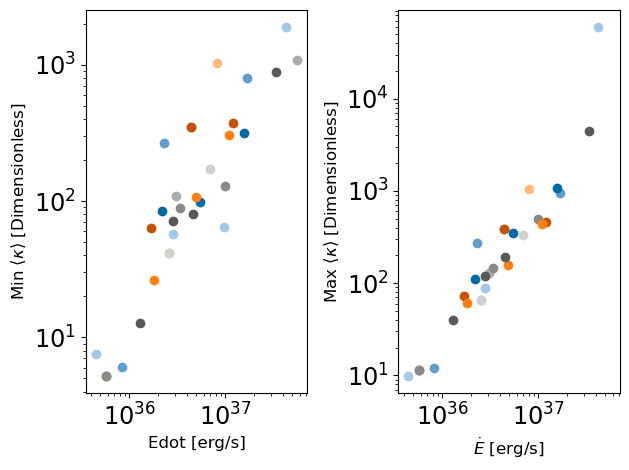

In [15]:
from scipy.stats import pearsonr

plt.figure(figsize=(20,6))
lines = [(0, (1, 3)),"-","--","-.",":"]
linecycler = cycle(lines)
#Now plot how the pair-production multiplicity varies with P0. 
color = cm.cividis(np.linspace(0, 1, len(df)))
#Only first 10 in df, as len(df) is a crowded plot
fig,axs=plt.subplots(1,2)
edots=[]
minkappas=[]
maxkappas=[]
for i in range(len(df)):
    
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)
    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    minkappa=k_p0[np.abs(test_p0.value-0.01).argmin()]
    maxkappa=k_p0[np.abs(test_p0.value-0.05).argmin()]
    axs[0].scatter(edot[i],minkappa)
    axs[1].scatter(edot[i],maxkappa)
    edots.append(edot[i].value)
    minkappas.append(minkappa)
    maxkappas.append(maxkappa)

axs[0].loglog()
axs[1].loglog()
axs[0].set_ylabel(r"Min $\langle\kappa\rangle$ [Dimensionless]",fontsize=12)
axs[0].set_xlabel("Edot [erg/s]",fontsize=12)
axs[1].set_ylabel(r"Max $\langle\kappa\rangle$ [Dimensionless]",fontsize=12)
axs[1].set_xlabel(r"$\dot{E}$ [erg/s]",fontsize=12)
plt.tight_layout()
print(minkappas,maxkappas)
print(pearsonr(np.asarray(edots)[~np.isnan(minkappas)],np.asarray(minkappas)[~np.isnan(minkappas)]))
print(pearsonr(np.asarray(edots)[~np.isnan(maxkappas)],np.asarray(maxkappas)[~np.isnan(maxkappas)]))
plt.savefig('kappaplotdiff.png',dpi=300)

[ 884.30273009  802.34309548  374.22718346  129.50054481 1029.97766875
  172.74052512   98.3811578   106.67209018  109.21976362   71.77424772
  267.7176211    63.93108785 1880.35405871  316.32811121  303.85420245
   80.07186104  351.37015598  351.37015598   88.92592693   57.09913125
   41.5851254    41.5851254    84.91253539   26.14146317   12.79815388
    6.07367511    5.20470694    5.20470694    7.61111594] [4.43028705e+03 9.38347228e+02 4.63989215e+02 4.95763208e+02
 1.05982297e+03 3.32748373e+02 3.48798028e+02 1.58802116e+02
 1.28283124e+02 1.18986198e+02 2.73346260e+02 7.30810986e+01
 5.91856798e+04 1.07253018e+03 4.34962712e+02 1.91217796e+02
 3.85713556e+02 3.85713556e+02 1.45088464e+02 8.95102590e+01
 6.48364658e+01 6.48364658e+01 1.11264358e+02 6.11189386e+01
 3.93682981e+01 1.18858438e+01 1.15769724e+01 1.15769724e+01
 9.84603195e+00]
29


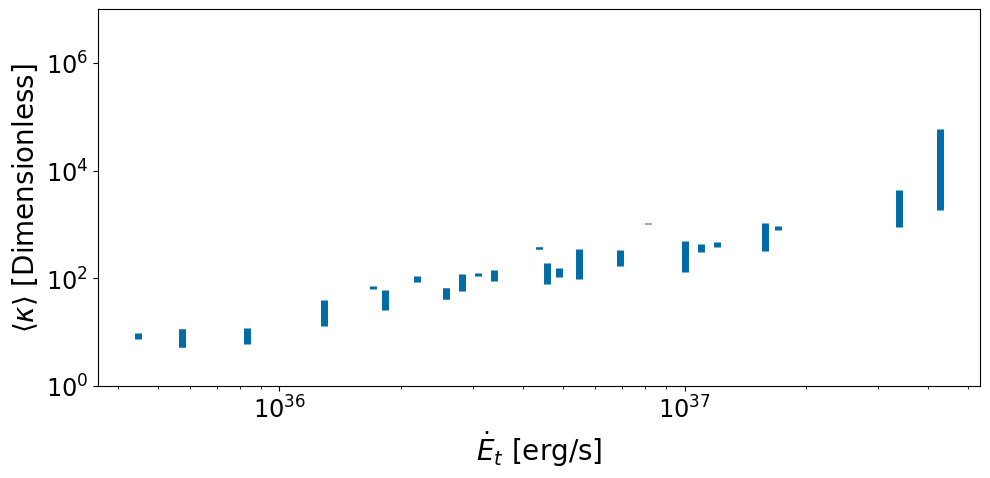

In [16]:
from itertools import cycle, islice
fig=plt.figure(figsize=(10,5))

def repeatlist(it, count):
    return islice(cycle(it), count)

#Filter out nan minkappas
truelocs=~np.isnan(minkappas)
minkappas=np.asarray(minkappas)[truelocs]
maxkappas=np.asarray(maxkappas)[truelocs]
edots=np.asarray(edots)[truelocs]
atnf_names=np.asarray(atnf_names)[truelocs]
#Filter out negative maxkappas
maxlocs=np.where(maxkappas>0)
minkappas=minkappas[maxlocs]
maxkappas=maxkappas[maxlocs]
edots=edots[maxlocs]
atnf_names=atnf_names[maxlocs]

print(minkappas,maxkappas)
ax=plt.gca()
prop_cycle = plt.rcParams['axes.prop_cycle']
color = repeatlist(prop_cycle.by_key()['color'],count=100)

for i in np.arange(len(edots)):
    plt.vlines(edots[i],minkappas[i],maxkappas[i],linewidths=5)
    #plt.text(edots[i],1e5,atnf_names[i],rotation=90)
#plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
print(len(minkappas))
plt.loglog()
plt.ylabel(r"$\langle\kappa\rangle$ [Dimensionless]",fontsize=20)
plt.ylim(1,1e7)
plt.xlabel(r"$\dot{E}_t$ [erg/s]",fontsize=20)
#plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('kapparange.png',dpi=300)

In [17]:
print(edots)
df = pd.DataFrame(columns=['Atnf_names', 'Edots times 10^36', 'minkappa','maxkappa'])
df['Atnf_names']=atnf_names
df['Edots times 10^36']=edots/10**36
df['minkappa']=minkappas
df['maxkappa']=maxkappas


print(df)

[3.39e+37 1.70e+37 1.20e+37 1.00e+37 8.13e+36 6.92e+36 5.50e+36 4.90e+36
 3.09e+36 2.82e+36 2.29e+36 1.70e+36 4.27e+37 1.58e+37 1.10e+37 4.57e+36
 4.37e+36 4.37e+36 3.39e+36 2.82e+36 2.57e+36 2.57e+36 2.19e+36 1.82e+36
 1.29e+36 8.32e+35 5.75e+35 5.75e+35 4.47e+35]
    Atnf_names Edots times 10^36     minkappa      maxkappa
0   J1833-1034              33.9   884.302730   4430.287050
1   J1513-5908              17.0   802.343095    938.347228
2   J1930+1852              12.0   374.227183    463.989215
3   J1420-6048              10.0   129.500545    495.763208
4   J1846-0258              8.13  1029.977669   1059.822969
5   J0835-4510              6.92   172.740525    332.748373
6   J1838-0655               5.5    98.381158    348.798028
7   J1418-6058               4.9   106.672090    158.802116
8   J1357-6429              3.09   109.219764    128.283124
9   J1826-1334              2.82    71.774248    118.986198
10  J1119-6127              2.29   267.717621    273.346260
11  J1301-6305

In [18]:
print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.0f}".format,))  

\begin{tabular}{llrr}
\toprule
Atnf_names & Edots times 10^36 & minkappa & maxkappa \\
\midrule
J1833-1034 & 33.900000 & 884 & 4430 \\
J1513-5908 & 17.000000 & 802 & 938 \\
J1930+1852 & 12.000000 & 374 & 464 \\
J1420-6048 & 10.000000 & 130 & 496 \\
J1846-0258 & 8.130000 & 1030 & 1060 \\
J0835-4510 & 6.920000 & 173 & 333 \\
J1838-0655 & 5.500000 & 98 & 349 \\
J1418-6058 & 4.900000 & 107 & 159 \\
J1357-6429 & 3.090000 & 109 & 128 \\
J1826-1334 & 2.820000 & 72 & 119 \\
J1119-6127 & 2.290000 & 268 & 273 \\
J1301-6305 & 1.700000 & 64 & 73 \\
J1747-2809 & 42.700000 & 1880 & 59186 \\
J1617-5055 & 15.800000 & 316 & 1073 \\
J1023-5746 & 11.000000 & 304 & 435 \\
J1856+0245 & 4.570000 & 80 & 191 \\
J1640-4631 & 4.370000 & 351 & 386 \\
J1640-4631 & 4.370000 & 351 & 386 \\
J1709-4429 & 3.390000 & 89 & 145 \\
J1907+0602 & 2.820000 & 57 & 90 \\
J1016-5857 & 2.570000 & 42 & 65 \\
J1016-5857 & 2.570000 & 42 & 65 \\
J1803-2137 & 2.190000 & 85 & 111 \\
J1809-1917 & 1.820000 & 26 & 61 \\
J1718-3825 & 1.29